<a href="https://colab.research.google.com/github/hyunsoo41/Umi/blob/main/Umi_Phoodrecipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Phoodrecipe(CNN food classifier & recipe printer)

* Add all the imports

In [2]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import keras.backend as K
from keras.models import load_model
import keras.utils as image
from keras import regularizers
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import SGD
from keras.regularizers import l2

from tensorflow import keras
from keras import models
from keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict
from google.colab import files

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [3]:
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 23737, done.
remote: Counting objects: 100% (701/701), done.
remote: Compressing objects: 100% (419/419), done.
remote: Total 23737 (delta 230), reused 558 (delta 194), pack-reused 23036
Receiving objects: 100% (23737/23737), 44.18 MiB | 29.74 MiB/s, done.
Resolving deltas: 100% (12879/12879), done.


In [4]:
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

* The Food-101 dataset is 5GB in size. This might take some time to finish..

In [6]:
get_data_extract()

4996278331/4996278331 [==============================] - 241s 0us/step
Dataset downloaded and extracted!


In [ ]:
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

In [ ]:
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

In [ ]:
train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

In [ ]:
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

# Create a subset of data with few classes (3)

In [ ]:
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest)
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
food_list = ['apple_pie','pizza','omelette']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
2250


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
750


# Fine tune Inception Pretrained model using Food 101 dataset

* Keras and other Deep Learning libraries provide pretrained models  
* These are deep neural networks with efficient architectures(like VGG,Inception,ResNet) that are already trained on datasets like ImageNet  
* Using these pretrained models, we can use the already learned weights and add few layers on top to finetune the model to our new data  
* This helps in faster convergance and saves time and computation when compared to models trained from scratch

* We currently have a subset of dataset with 3 classes - samosa, pizza and omelette  
* Use the below code to finetune Inceptionv3 pretrained model

In [ ]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height =
  train_data_dir = 'food-101/train_mini'
  validation_data_dir = 'food-101/test_mini'
  batch_size = 16

  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)

  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)

  csv_logger = CSVLogger(history_path)

  history = model.fit_generator(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [ ]:
n_classes = 3
epochs = 50
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
87910968/87910968 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-16-1a074316ca40>:76: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, #훈련 데이터 셋


Epoch 1/30
140/140 [==============================] - ETA: 0s - loss: 1.0618 - accuracy: 0.4785
Epoch 1: val_loss improved from inf to 0.86844, saving model to bestmodel_3class.hdf5
140/140 [==============================] - 94s 520ms/step - loss: 1.0618 - accuracy: 0.4785 - val_loss: 0.8684 - val_accuracy: 0.7038
Epoch 2/30
140/140 [==============================] - ETA: 0s - loss: 0.8320 - accuracy: 0.6858
Epoch 2: val_loss improved from 0.86844 to 0.68143, saving model to bestmodel_3class.hdf5
140/140 [==============================] - 66s 473ms/step - loss: 0.8320 - accuracy: 0.6858 - val_loss: 0.6814 - val_accuracy: 0.7908
Epoch 3/30
140/140 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.7525
Epoch 3: val_loss improved from 0.68143 to 0.54119, saving model to bestmodel_3class.hdf5
140/140 [==============================] - 67s 479ms/step - loss: 0.6936 - accuracy: 0.7525 - val_loss: 0.5412 - val_accuracy: 0.8492
Epoch 4/30
140/140 [========================

# Visualize the accuracy and loss plots

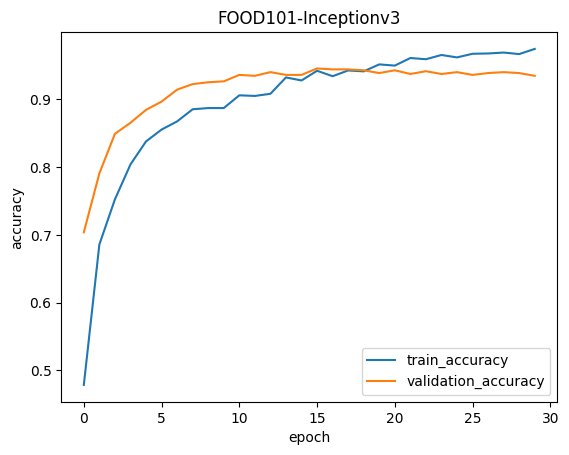

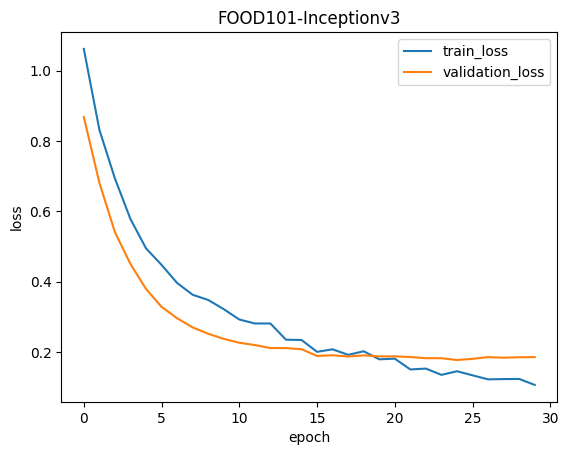

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

* The plots show that the accuracy of the model increased with epochs and the loss has decreased
* Validation accuracy has been on the higher side than training accuracy for many epochs
* This could be for several reasons:
  * We used a pretrained model trained on ImageNet which contains data from a variety of classes
  * Using dropout can lead to a higher validation accuracy
* The best model saved has a Top-1 validation accuracy of 93%



# Predicting classes for new images from internet using the best trained model

In [ ]:
%%time

K.clear_session()
model_best = load_model('bestmodel_3class.hdf5',compile = False)

CPU times: user 2.75 s, sys: 95.7 ms, total: 2.84 s
Wall time: 2.81 s


* **Setting compile=False and clearing the session leads to faster loading of the saved model**
* **Withouth the above addiitons, model loading was taking more than a minute!**

In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]

    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

    if (os.path.isfile('/content/%s.txt'%pred_value)):
      with open('/content/%s.txt'%pred_value) as file_object:
        contents = file_object.read()
        print(contents)
    else:
      print("Sorry, we have no recipe.")


In [ ]:
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://simplyhomecooked.com/wp-content/uploads/2020/04/apple-pie-recipe-13-scaled.jpg
images = []

--2023-06-03 10:03:59--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 45.77.209.234
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|45.77.209.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75560 (74K) [image/jpeg]
Saving to: ‘samosa.jpg’

samosa.jpg          100%[===================>]  73.79K  --.-KB/s    in 0.02s   

2023-06-03 10:03:59 (4.21 MB/s) - ‘samosa.jpg’ saved [75560/75560]

--2023-06-03 10:03:59--  https://simplyhomecooked.com/wp-content/uploads/2020/04/apple-pie-recipe-13-scaled.jpg
Resolving simplyhomecooked.com (simplyhomecooked.com)... 172.67.171.100, 104.21.29.58, 2606:4700:3033::6815:1d3a, ...
Connecting to simplyhomecooked.com (simplyhomecooked.com)|172.67.171.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98247 (96K) [image/jpeg]
Saving to: ‘applepie.jpg’

applepie.jpg        100%[==================

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving image.jpg to image.jpg
User uploaded file "image.jpg" with length 143686 bytes


1/1 [==============================] - 0s 43ms/step


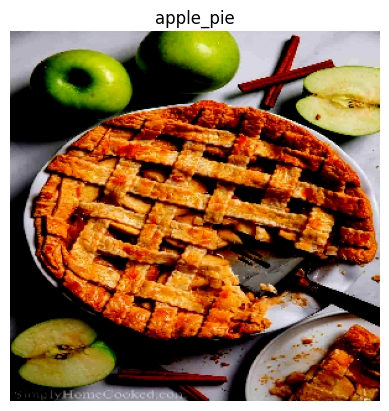

Sorry, we have no recipe.
1/1 [==============================] - 0s 39ms/step


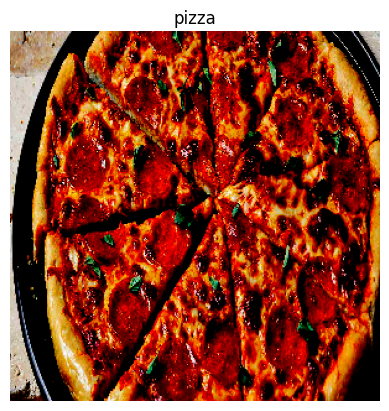

Sorry, we have no recipe.


In [ ]:
images.append('image.jpg')

predict_class(model_best, images, True)